In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math 
import scipy.integrate as integrate
from scipy.interpolate import UnivariateSpline
import mpmath

class Tools():
    def __init__(self, **kwargs):
        self.alpha = 887.2
        self.__dict__.update(kwargs)
    def correy_function(self, saturation_oil, saturation_water):
        effective_water = (saturation_water - self.connate_water)/(1-self.connate_water)
        kro = (1-effective_water**2) * (1 - effective_water)**2
        # print(kro, ':', saturation_oil)
        krw = effective_water**4
        return kro, krw
    def mobility_ratio_function(self, relative_permeability):
        return (relative_permeability[1]/self.water_viscosity) / (relative_permeability[0]/self.oil_viscosity)
    def oil_mobility(self, relative_permeability):
        return relative_permeability[0]/self.oil_viscosity
    def water_mobility(self, relative_permeability):
        return relative_permeability[1]/self.water_viscosity
    def total_mobility(self, relative_permeability):
        return self.oil_mobility(relative_permeability) + self.water_mobility(relative_permeability)
    def irreducable_oil_mobility(self):
        return self.correy_function(self.i_saturation_oil, self.connate_water)[0]/self.oil_viscosity
    def darcy_coefficent(self, formation_permeability = None, pay = None):
        if formation_permeability == None:
            formation_permeability = self.formation_permeability
        if pay == None:
            formation_permeability = self.pay_thickness
        return self.alpha * self.formation_volumn_water / (2 * math.pi * formation_permeability * self.irreducable_oil_mobility * pay)
    def fractional_flow(self, pay, injection = None, saturation = None):
        if saturation == None:
            saturation = np.arange(self.connate_water, 1 - self.residual_oil, 0.1)
        if injection == None:
            injection = self.injection
        self.water_saturation = saturation
        mobility_ratio = [self.mobility_ratio_function(self.correy_function(self.current_oil, i)) for i in saturation]
        fractional_flow= [i / (i+1 ) for i in mobility_ratio]
        grad = np.gradient(fractional_flow)
        self.position_profile = [(self.rw**2 + self.formation_volumn_water*injection*self.total_time*grad[-i -1]/ (math.pi * self.porosity * pay))**.5 for i in range(0, len(saturation))]
        self.floodfront = self.position_profile[0]
#         print(self.position_profile)
        return self.position_profile
        
    def oil_mobility_at_position(self, r, darcy_coefficent):
        if r == self.rw:
            return darcy_coefficent*self.total_mobility(self.correy_function(self.residual_oil, 1 - self.residual_oil))
        if r == self.floodfront:
            return darcy_coefficent*self.total_mobility(self.correy_function(1-self.connate_water,  self.connate_water))
        interpolationFunc = UnivariateSpline(self.position_profile[::-1], self.water_saturation[::-1])
        water_sat_at_r = interpolationFunc(r)
        return darcy_coefficent*self.total_mobility(self.correy_function(1 - water_sat_at_r, water_sat_at_r))
    def A_weight(self, permeability, pay, injection):
        x = self.fractional_flow(injection, pay)
#         print(self.floodfront)
        aj, aj_err = integrate.quad(self.oil_mobility_at_position,self.rw, self.floodfront, self.darcy_coefficent(permeability, pay))
#         print('aj', aj)
        return aj

class simu(Tools):
    def __init__(self, pay_thickness, formation_permeability, **kwargs):
        super().__init__()
        self.pay_thickness = pay_thickness
        self.formation_permeability = formation_permeability
        self.__dict__.update(kwargs)
        self.total_time = self.step_time
        self.irreducable_oil_mobility = super().irreducable_oil_mobility()
        self.couple_flow_cap = []
        for i in range(len(self.pay_thickness)):
            self.couple_flow_cap.append((self.formation_permeability[i], self.pay_thickness[i]))
        # print(self.couple_flow_cap)
        self.flowcapacity = [i[0]*i[1] for i in self.couple_flow_cap]
        avg = sum(self.flowcapacity)
        self.injections_per_layer = [self.injection*i/avg for i in self.flowcapacity]
        self.current_oil = self.i_saturation_oil
        self.times = []

    def eta_coefficent(self):
        return [i*self.irreducable_oil_mobility / (self.porosity*self.total_compressibility_initial) for i in self.formation_permeability]

    def laplace_domain_oil_at_time_t_multiple_layer(self, time = None):

        coefficent = self.alpha * self.injection * self.formation_volumn_water / (2* math.pi * self.irreducable_oil_mobility* time)
        sumation_element = []
        for i in range(len(self.pay_thickness)):
            E = self.rw*(time/self.eta_coefficent()[i])**0.5
            A = mpmath.besselk(1, E)
            C = mpmath.besselk(0,E)
            B = self.formation_permeability[i]*self.pay_thickness[i]*E*A / C
            sumation_element.append(B)
        return coefficent/sum(sumation_element)
    def initial_oil_pressure_change_at_time(self, time = None):
        if time == None:
            time = self.total_time
        self.initial_oil_pressure_change = mpmath.invertlaplace(self.laplace_domain_oil_at_time_t_multiple_layer, time, method = 'stehfest')
        return self.initial_oil_pressure_change

    def WB_pressure_change(self):
        A = []
#         print(self.total_time)
        for i in range(len(self.injections_per_layer)):

            A.append(super().A_weight(self.couple_flow_cap[i][0],self.couple_flow_cap[i][1], self.injections_per_layer[i]))
        # A = sum([super().A_weight(self.couple_flow_cap[i][0],self.couple_flow_cap[i][1], self.injections_per_layer[i]) for i in range(len(self.injections_per_layer))])
        self.wellbore_pressure_change = self.initial_oil_pressure_change_at_time() + 1/sum(A)
        self.times.append(self.total_time)
        return self.wellbore_pressure_change

    def update_injection(self):
#         print(self.injections_per_layer)
        for i in range( len( self.injections_per_layer)):

            A = super().A_weight(self.couple_flow_cap[i][0],self.couple_flow_cap[i][1], self.injections_per_layer[i])
            # print(self.injections_per_layer[i], 'injection')

            self.injections_per_layer[i] =  (self.wellbore_pressure_change - self.initial_oil_pressure_change) / A


    def run(self, iterations):
        wellbore_pressure_changes = []
        for i in range(iterations):
            c = self.WB_pressure_change()
#             print(c, 'c\n\n')
            wellbore_pressure_changes.append(c)
            self.update_injection()
#             print(self.injections_per_layer, 'injections')
            self.total_time += self.step_time
        self.w_p_c = wellbore_pressure_changes
        return wellbore_pressure_changes
    
    def de_pc(self): 
        return np.gradient(self.w_p_c)
    def get_time(self):
        return self.times
        







[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7, 0.7999999999999999, 0.8999999999999999, 0.9999999999999999]
[mpf('888.78524763060261'), mpf('920.35040395803242'), mpf('938.84258815655471'), mpf('952.18575205905972'), mpf('962.63895977482218'), mpf('971.21134245431961'), mpf('978.46704206217726'), mpf('984.75392283102963'), mpf('990.29966810050303'), mpf('995.26055125041341')]


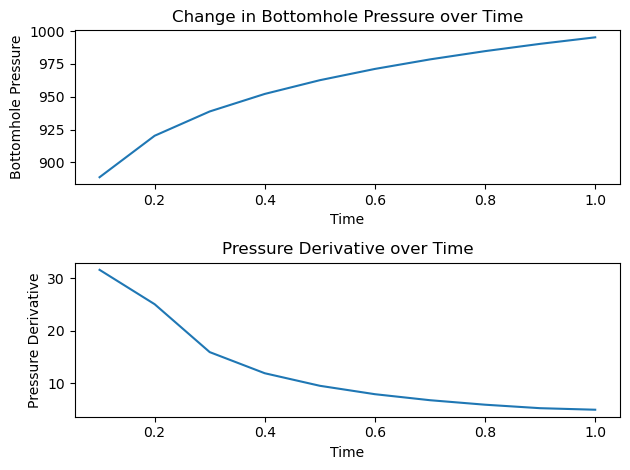

In [16]:
Properties = dict(total_compressibility_initial = 0.00000198,
    injection = 60, porosity = 0.11,rw = 0.1, 
    formation_volumn_water = 1.1, 
    step_time = 0.1, connate_water = 0.2, residual_oil = 0.4,
     water_viscosity = 1, oil_viscosity = 2, i_saturation_oil = 0.8, 
    i_saturation_water = 0.2, formation_permeability = [5,2,4], pay_thickness = [10,50,12])

s = simu(**Properties)
delta_pwf = s.run(10)
times = s.get_time()
pressure_derivative = s.de_pc()
print(times)

print(delta_pwf)


fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(times, delta_pwf)
ax1.set_title('Change in Bottomhole Pressure over Time')
ax1.set_xlabel('Time')
ax1.set_ylabel('Bottomhole Pressure')

ax2.plot(times, pressure_derivative)
ax2.set_title('Pressure Derivative over Time')
ax2.set_xlabel('Time')
ax2.set_ylabel('Pressure Derivative')

plt.tight_layout()
plt.show()